In [77]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle 
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks_cwt
%matplotlib inline


(1280, 720)


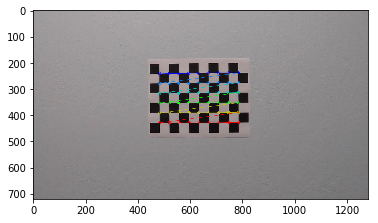

In [78]:
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# Make a list of calibration images
fname = 'camera_cal/calibration6.jpg'
img = cv2.imread(fname)
img_size = (img.shape[1], img.shape[0])
print(img_size)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)

## Camera Calibration
This is an OpenCV Tutorial about [Camera Calibration](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html).

In [79]:

objpoints = []
imgpoints = []

objp = np.zeros((6*9,3),np.float32)
#(2,8,6)-->(6,8,2)-->(48,2)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for i in range(20):
    fname = 'camera_cal/calibration'+ str(i+1) + '.jpg'
    img = cv2.imread(fname)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

In [80]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(img_size[1],img_size[0]),1,(img_size[1],img_size[0]))
x1,y1,y2,x2 = roi

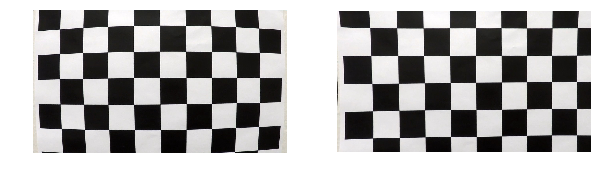

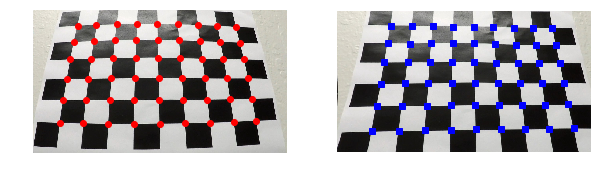

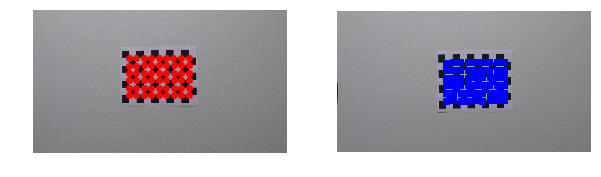

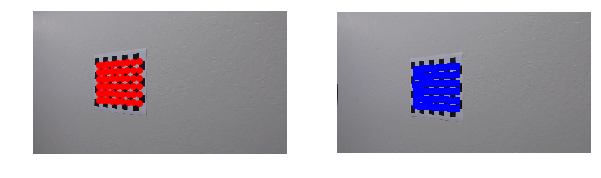

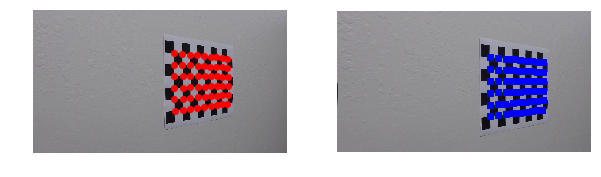

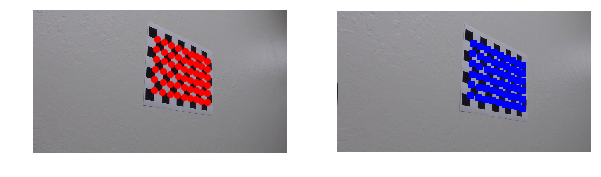

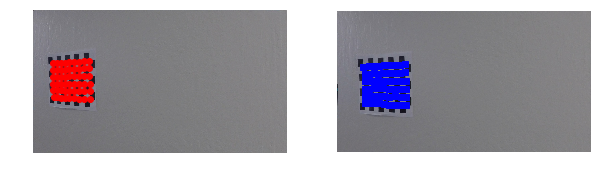

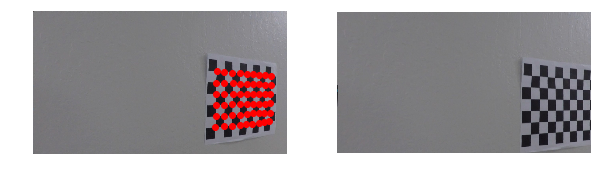

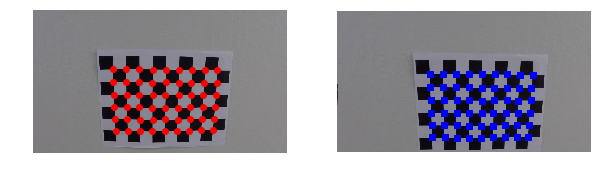

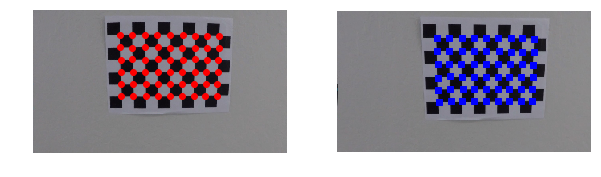

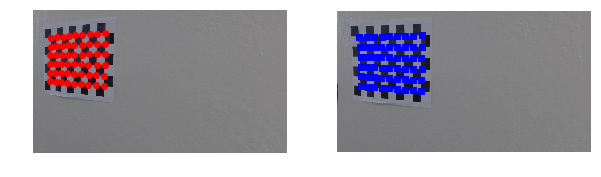

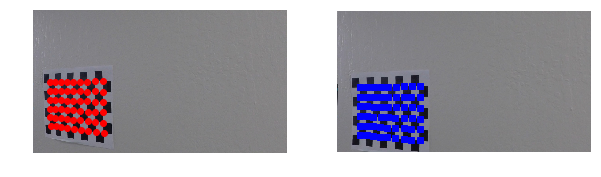

In [81]:
for i in range(20):
    fname = 'camera_cal/calibration'+ str(i+1) + '.jpg'
    img = cv2.imread(fname)[:,:,::-1]
    img_size = (img.shape[1], img.shape[0])
    plt.figure(figsize=(10,4))


    undist = cv2.undistort(img, mtx, dist, None, newcameramtx)
    plt.subplot(1,2,1)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    ret_ud, corners_ud = cv2.findChessboardCorners(undist[y1:y2,x1:x2], (nx, ny), None)
 
    if ret == True:
        for i_c in range(len(corners)):
            plt.plot(corners[i_c][0][0],corners[i_c][0][1],'ro')
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(undist[y1:y2,x1:x2])
    if ret_ud == True:
        for i_c in range(len(corners_ud)):
            plt.plot(corners_ud[i_c][0][0],corners_ud[i_c][0][1],'bs')
    plt.axis('off');

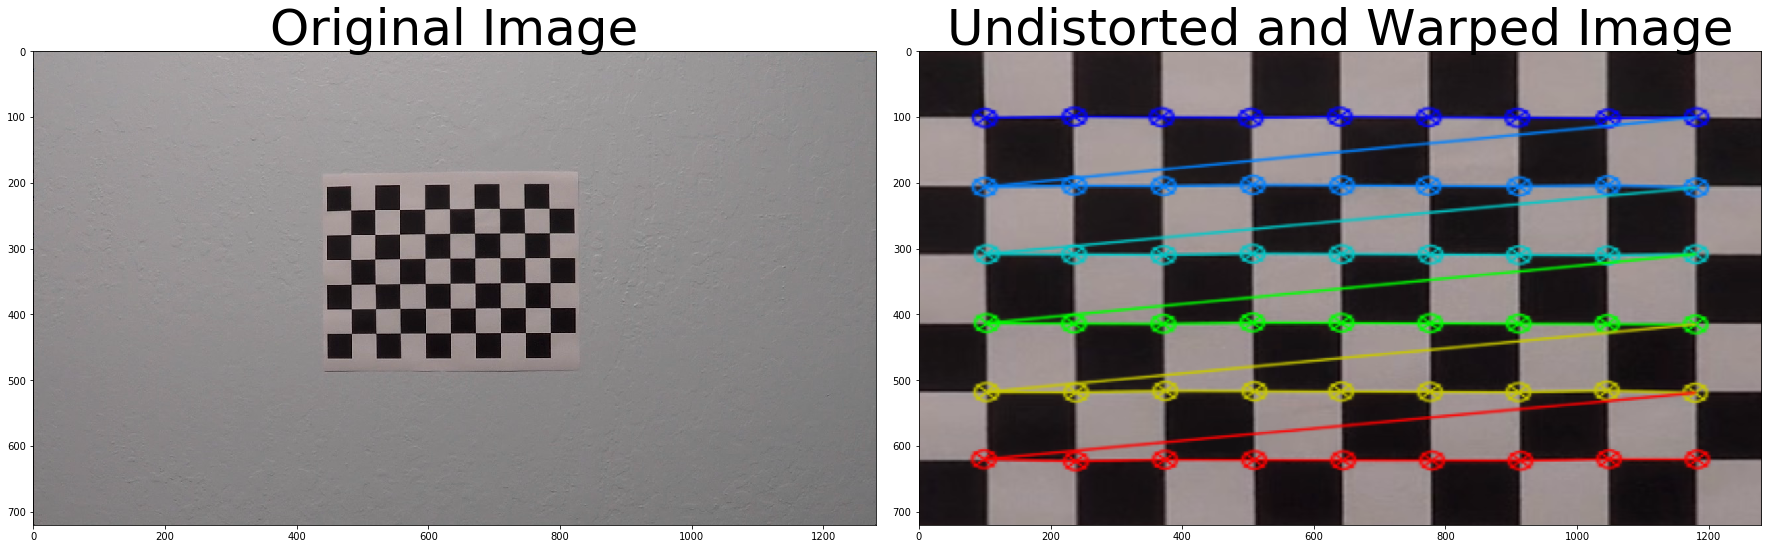

In [83]:
fname = 'camera_cal/calibration6.jpg'
img = cv2.imread(fname)
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

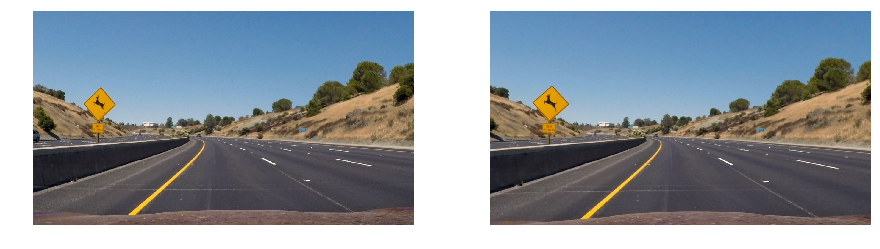

In [257]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
#Read an image
img = mpimg.imread('test_images/test2.jpg')
plt.axis('off')
plt.imshow(img)
plt.subplot(1,2,2)
#undistort
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.axis('off')
plt.imshow(undist)


In [258]:
#Convert an image to Bird-eye view
def convert_image(img):
    height,width = img.shape[:2]
    src = np.float32([[0.4*width,0.65*height],[0.6*width,0.65*height],[0.95*width,1.*height],[0.05*width,1.*height]])
    dst = np.float32([[0,0],[width,0],[width,height],[0,height]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped,M,Minv
warped,M,Minv = convert_image(undist)

In [259]:
height,width = img.shape[:2]
src = np.float32([[0.4*width,0.65*height],[0.6*width,0.65*height],[0.95*width,1.*height],[0.05*width,1.*height]])
dst = np.float32([[0,0],[width,0],[width,height],[0,height]])
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
for i in range(4):
    plt.plot(src[i][0],src[i][1],'rs')
plt.imshow(undist)
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(warped)
for i in range(4):
    plt.plot(dst[i][0],dst[i][1],'rs')
    
plt.title('Bird-eye view')
plt.axis('off');

## Color Mask

In [260]:
image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)
mask_yellow = cv2.inRange(image_HSV, np.array([10,100,100]), np.array([35,255,255]))
res_yellow = cv2.bitwise_and(warped,warped, mask= mask_yellow)
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(warped)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(res_yellow)
plt.axis('off');

In [261]:
mask_white = cv2.inRange(image_HSV, np.array([0,0,200]), np.array([180,30,255]))
res_white = cv2.bitwise_and(warped,warped, mask= mask_white)
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(warped)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(res_white)
plt.axis('off');

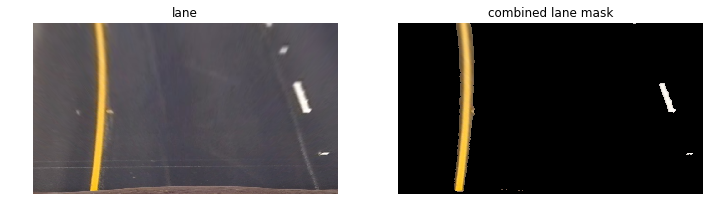

In [262]:
def color_mask(warped):
    image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)
    mask_yellow = cv2.inRange(image_HSV, np.array([10,80,40]), np.array([35,255,255]))
    #plt.imshow(mask_yellow)
    #res_yellow = cv2.bitwise_and(warped,warped, mask= mask_yellow)
    mask_white = cv2.inRange(image_HSV, np.array([0,0,200]), np.array([180,30,255]))
    #res_white = cv2.bitwise_and(warped,warped, mask= mask_white)
    combined_mask = cv2.bitwise_or(mask_yellow,mask_white)
    mask_lane = np.zeros_like(combined_mask)
    mask_lane[(combined_mask > 0)] = 1
    return mask_lane

color_mask_lane = color_mask(warped)
res = cv2.bitwise_and(warped,warped, mask= color_mask_lane)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('lane')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(res,cmap='gray')
plt.title('combined lane mask')
plt.axis('off');
    

## Todo SLIC ......

(-0.5, 255.5, 143.5, -0.5)

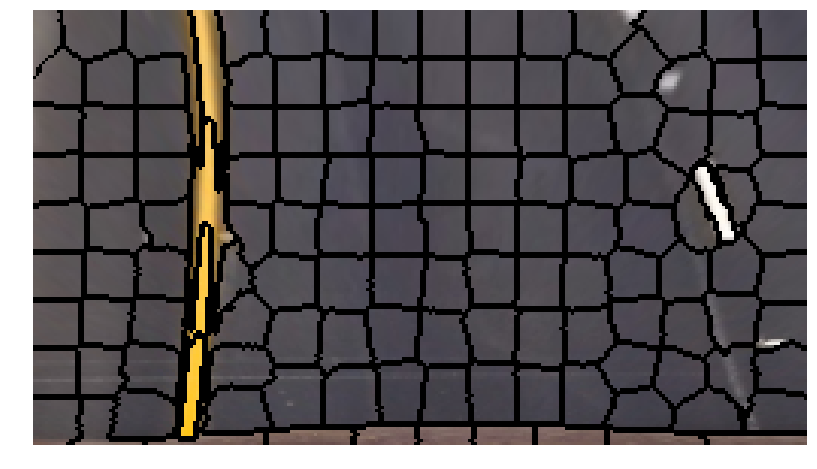

In [263]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
res = cv2.resize(warped, (256,144), interpolation = cv2.INTER_AREA)
segments = slic(res, n_segments = 150,max_size_factor = 2)
plt.figure(figsize=(15,8))
plt.imshow(mark_boundaries(res, segments, color = (0,0,0)))
plt.axis("off")


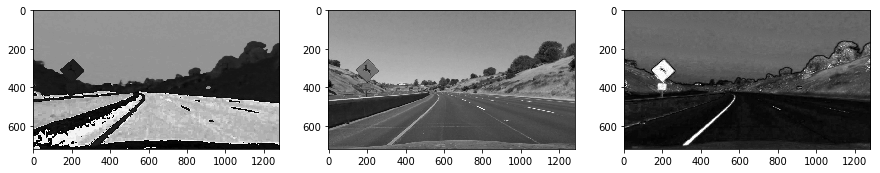

In [264]:
image_HLS = cv2.cvtColor(undist,cv2.COLOR_RGB2HLS)
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.imshow(image_HLS[:,:,0],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(image_HLS[:,:,1],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(image_HLS[:,:,2],cmap='gray')

##  Sobel Mask(Not very well)

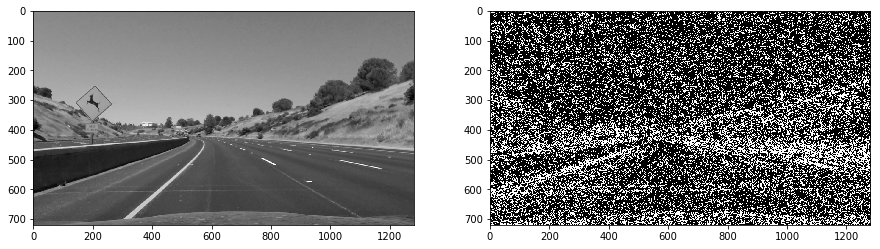

In [265]:
def sobel_mask_dir(image, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)     
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(sobel_mask_dir(undist,thresh=(1.1,1.5)),cmap='gray')

In [266]:
def sobel_mask_grad(image, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)     
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    scaled_sobel = cv2.convertScaleAbs(gradmag)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    
    #mask_lane = cv2.bitwise_or(sxbinary,sybinary)
    return binary_output
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(sobel_mask_grad(undist,mag_thresh=(50, 255)),cmap='gray')

In [267]:
def sobel_mask_orient(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    scaled_sobel = cv2.convertScaleAbs(sobelx)
    thresh_min = 50
    thresh_max = 230
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)]=1
        
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    scaled_sobel = cv2.convertScaleAbs(sobely)
    thresh_min = 50
    thresh_max = 200
    sybinary = np.zeros_like(scaled_sobel)
    sybinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)]=1
    
    mask_lane = cv2.bitwise_or(sxbinary,sybinary)
    
    return mask_lane

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(sobel_mask_orient(undist),cmap='gray')
    

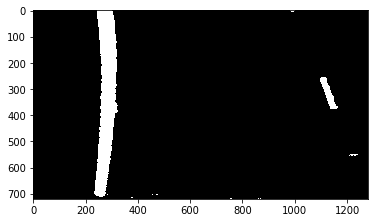

In [268]:
def get_mask_lane(warped):
    color_mask_lane = color_mask(warped)
    #sobel_mask_lane = sobel_mask(warped)
    #mask_lane = np.zeros_like(color_mask_lane)
    #mask_lane[(color_mask_lane > 0) | (sobel_mask_lane > 0)] = 1
    return color_mask_lane

mask_lane = get_mask_lane(warped)
plt.imshow(mask_lane,cmap='gray')

In [269]:
def window_center(mask_img,nrows = 15,threshold =50):
    left_list = [[] for i in range(nrows+1)]
    right_list = [[] for i in range(nrows+1)]
    left_center_list,right_center_list = [],[]
    midpoint = img.shape[1]//2
    window_y_size = mask_img.shape[0]//nrows
    for y_position in range(mask_img.shape[0]):
        for x_position in range(mask_img.shape[1]):
            if mask_img[y_position][x_position] == 1:
                y_window_position = y_position//window_y_size
                if x_position < midpoint:left_list[y_window_position].append(x_position)
                else:right_list[y_window_position].append(x_position)
                    
    for i in range(nrows-1):
        if len(left_list[i]) > threshold:
            left_center_list.append((sorted(left_list[i])[len(left_list[i])//2],int((i+0.5)*window_y_size)))
        if len(right_list[i]) > threshold:
            right_center_list.append((sorted(right_list[i])[len(right_list[i])//2],int((i+0.5)*window_y_size)))
    return left_center_list,right_center_list

left_center_list,right_center_list = window_center(mask_lane,nrows = 20)
print (left_center_list,right_center_list)

            

[(275, 18), (280, 54), (284, 90), (286, 126), (289, 162), (289, 198), (289, 234), (289, 270), (288, 306), (287, 342), (289, 378), (283, 414), (281, 450), (278, 486), (275, 522), (272, 558), (268, 594), (263, 630), (259, 666)] [(991, 18), (1111, 270), (1124, 306), (1137, 342), (1148, 378), (1225, 558)]


In [270]:
def draw_window(mask_img,left_center_list,right_center_list,window_x_size = 100,nrows = 15):
    window_y_size = mask_img.shape[0]//nrows
    mask_img = np.dstack((mask_img, mask_img, mask_img))*255
    for i in range(len(left_center_list)):
        left_x_low = left_center_list[i][0]-window_x_size//2
        left_x_high = left_center_list[i][0]+window_x_size//2
        left_y_low = left_center_list[i][1]-window_y_size//2
        left_y_high = left_center_list[i][1]+window_y_size//2
        cv2.rectangle(mask_img,(left_x_low,left_y_low),(left_x_high,left_y_high),(0,255,0), 3) 
        
    for i in range(len(right_center_list)):
        right_x_low = right_center_list[i][0]-window_x_size//2
        right_x_high = right_center_list[i][0]+window_x_size//2
        right_y_low = right_center_list[i][1]-window_y_size//2
        right_y_high = right_center_list[i][1]+window_y_size//2
        cv2.rectangle(mask_img,(right_x_low,right_y_low),(right_x_high,right_y_high),(0,255,0), 3)
        
    return mask_img

mask_img_window = draw_window(mask_lane,left_center_list,right_center_list,nrows = 20)
plt.figure(figsize=(12,6))
plt.imshow(mask_img_window)

In [271]:
def left_right_line(mask_img,left_center_list,right_center_list):
    
    #find two lines' function
    left_center_list = np.array(left_center_list)
    right_center_list = np.array(right_center_list)
    left_fit = np.polyfit(left_center_list[:,1], left_center_list[:,0], 2)
    right_fit = np.polyfit(right_center_list[:,1], right_center_list[:,0], 2)
    #find the left line and the right line
    ploty = np.linspace(0, mask_img.shape[0]-1, mask_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty,left_fitx,right_fitx

ploty,left_fitx,right_fitx = left_right_line(mask_lane,left_center_list,right_center_list)
print("ploty size:",ploty.shape[0])
print("left_fitx size:",left_fitx.shape[0])
print("right_fitx size:",right_fitx.shape[0])

ploty size: 720
left_fitx size: 720
right_fitx size: 720


In [273]:
def Radius(mask_img,left_center_list,right_center_list):
    
    left_center_list = np.array(left_center_list)
    right_center_list = np.array(right_center_list)

    ym_per_pix = 5/200 # meters per pixel in y dimension
    xm_per_pix = 3.75/1000 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(left_center_list[:,1]*ym_per_pix, left_center_list[:,0]*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_center_list[:,1]*ym_per_pix, right_center_list[:,0]*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*mask_img.shape[0]*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*mask_img.shape[0]*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    car_position = (mask_img.shape[1]/2)*xm_per_pix
    l_fit_x_int = left_fit_cr[0]*(mask_img.shape[0]*xm_per_pix)**2 + left_fit_cr[1]*(mask_img.shape[0]*xm_per_pix) + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*(mask_img.shape[0]*xm_per_pix)**2 + right_fit_cr[1]*(mask_img.shape[0]*xm_per_pix) + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center_dist = (car_position - lane_center_position)
    return left_curverad, right_curverad, center_dist
left_curverad,right_curverad,center_dist = Radius(mask_lane,left_center_list,right_center_list)

print (left_curverad,right_curverad,center_dist)

429.985255739 843.555133111 -0.0724683670405


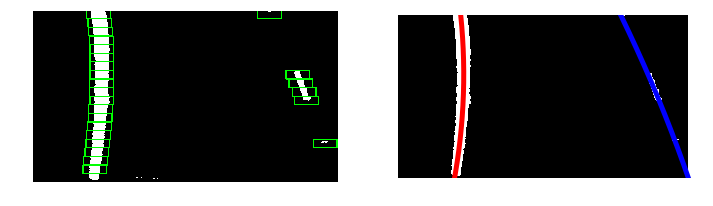

In [274]:
def draw_line(mask_img,ploty,left_fitx,right_fitx):
    
    mask_img = np.dstack((mask_img, mask_img, mask_img))*255
    
    ploty,left_fitx,right_fitx = left_right_line(mask_lane,left_center_list,right_center_list)
    
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.imshow(mask_img_window)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask_img)
    plt.plot(left_fitx,ploty, color='red', linewidth=5)
    plt.plot(right_fitx,ploty, color='blue', linewidth=5)
    plt.axis('off')
    return 

draw_line(mask_lane,ploty,left_fitx,right_fitx)


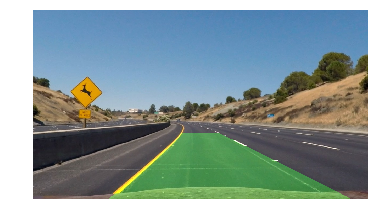

In [279]:
def combine_origin_mask(img,mask_lane,ploty,left_fitx,right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(mask_lane).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    plt.axis('off')
    
    return result

result_image = combine_origin_mask(undist,mask_lane,ploty,left_fitx,right_fitx)

In [280]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

img = draw_data(result_image,left_curverad,center_dist)
plt.imshow(img)

In [283]:
def find_lane(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)    
    height,width = undist.shape[:2]
    warped,M,Minv = convert_image(undist)
    mask_lane = color_mask(warped)
    left_center_list,right_center_list = window_center(mask_lane,nrows = 15,threshold = 100)
    ploty,left_fitx,right_fitx = left_right_line(mask_lane,left_center_list,right_center_list)
    result_image = combine_origin_mask(undist,mask_lane,ploty,left_fitx,right_fitx)
    left_curverad,right_curverad,center_dist = Radius(mask_lane,left_center_list,right_center_list)
    result_image = draw_data(result_image,left_curverad,center_dist)
    
    return result_image

img = mpimg.imread('test_images/test1.jpg')
result_image = find_lane(img)
plt.imshow(result_image)

In [284]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'project_video_result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(find_lane) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [34:46<00:01,  1.55s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 35min 47s, sys: 11.6 s, total: 35min 58s
Wall time: 34min 47s


In [285]:
HTML("""
<video width="800" height="500" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video challenge_video.mp4
[MoviePy] Writing video challenge_video.mp4


  1%|          | 5/485 [00:09<14:39,  1.83s/it]

IndexError: too many indices for array

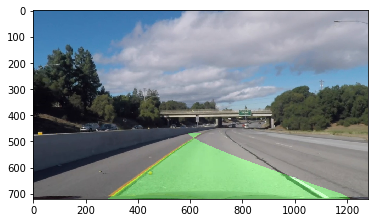

In [134]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(find_lane) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="800" height="500" controls>
  <source src="{0}">
</video>
""".format(white_output))